In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext cython

In [2]:
def local_exp_editsim(mat1, mat2, a = 0.01):
    nrow = mat1.shape[1]
    ncol = mat2.shape[1]
    dp = np.zeros((nrow+1, ncol+1))
    dp_max = 0
    dp_max_x = -1
    dp_max_y = -1
    down = np.zeros((nrow+1, ncol+1), dtype=np.int)
    right = np.zeros((nrow+1, ncol+1), dtype=np.int)
    for col1 in range(nrow):
        for col2 in range(ncol):
            match = np.dot(mat1[:, col1], mat2[:, col2])
            # For Down
            # Comparing options: newly extend a gap or extend the exsinting gap
            which_dir = np.argmax([
                dp[col1, col2+1] - np.exp(a) + 1,
                dp[col1-down[col1, col2+1], col2+1] - np.exp(a*(down[col1, col2+1] + 1)) + 1
            ])
            down[col1+1, col2+1] = 1 if which_dir == 0 else down[col1, col2+1] + 1
            down_score = dp[col1-down[col1+1, col2+1]+1, col2+1] - np.exp(a*down[col1+1, col2+1]) + 1
            # For Rightp
            # Comparing options: newly extend a gap or extend the exsinting gap
            which_dir = np.argmax([
                dp[col1+1, col2] - np.exp(a) + 1,
                dp[col1+1, col2-right[col1+1, col2]] - np.exp(a*(right[col1+1, col2] + 1)) + 1
            ])
            right[col1+1, col2+1] = 1 if which_dir == 0 else right[col1+1, col2] + 1
            right_score = dp[col1+1, col2-right[col1+1, col2+1]+1] - np.exp(a*right[col1+1, col2+1]) + 1
            # Update dp
            dp[col1+1, col2+1] = np.max([
                0,
                down_score,
                right_score,
                dp[col1, col2] + match
            ])
            if dp[col1+1, col2+1] > dp_max:
                dp_max = dp[col1+1, col2+1]
                dp_max_x = col1 + 1
                dp_max_y = col2 + 1
    return dp_max, dp_max_x, dp_max_y

In [3]:
def local_exp_editsim_withbp(mat1, mat2, a = 0.01):
    nrow = mat1.shape[1]
    ncol = mat2.shape[1]
    dp = np.zeros((nrow+1, ncol+1))
    bp = np.ones_like(dp) * (-1)
    dp_max = 0
    dp_max_x = -1
    dp_max_y = -1
    down = np.zeros((nrow+1, ncol+1), dtype=np.int)
    right = np.zeros((nrow+1, ncol+1), dtype=np.int)
    for col1 in range(nrow):
        for col2 in range(ncol):
            match = np.dot(mat1[:, col1], mat2[:, col2])
            # For Down
            # Comparing options: newly extend a gap or extend the exsinting gap
            which_dir = np.argmax([
                dp[col1, col2+1] - np.exp(a) + 1,
                dp[col1-down[col1, col2+1], col2+1] - np.exp(a*(down[col1, col2+1] + 1)) + 1
            ])
            down[col1+1, col2+1] = 1 if which_dir == 0 else down[col1, col2+1] + 1
            down_score = dp[col1-down[col1+1, col2+1]+1, col2+1] - np.exp(a*down[col1+1, col2+1]) + 1
            # For Rightp
            # Comparing options: newly extend a gap or extend the exsinting gap
            which_dir = np.argmax([
                dp[col1+1, col2] - np.exp(a) + 1,
                dp[col1+1, col2-right[col1+1, col2]] - np.exp(a*(right[col1+1, col2] + 1)) + 1
            ])
            right[col1+1, col2+1] = 1 if which_dir == 0 else right[col1+1, col2] + 1
            right_score = dp[col1+1, col2-right[col1+1, col2+1]+1] - np.exp(a*right[col1+1, col2+1]) + 1
            choices = [
                0,
                down_score,
                right_score,
                dp[col1, col2] + match
            ]
            # Update dp
            choice = np.argmax(choices)
            dp[col1+1, col2+1] = choices[choice]
            bp[col1+1, col2+1] = choice
            if dp[col1+1, col2+1] > dp_max:
                dp_max = dp[col1+1, col2+1]
                dp_max_x = col1 + 1
                dp_max_y = col2 + 1
    return dp_max, dp_max_x, dp_max_y, bp

In [111]:
sequence = np.eye(5)
mat1 = np.zeros((5, 20))
mat1[4, 15] = 1
mat2 = np.zeros((5, 20))
mat1[:, 0:5] = sequence[:, :]
mat2[:, [5, 16, 17, 18, 19]] = sequence[:, :]

In [129]:
dp_max, dp_max_x, dp_max_y, bp = local_exp_editsim_withbp(mat1, mat2, a = 0.5)

In [130]:
dp_max, dp_max_x, dp_max_y

(4.0, 5, 20)

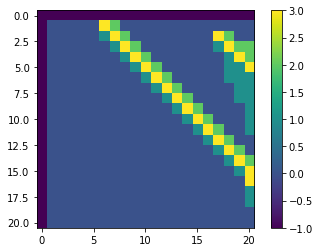

In [131]:
plt.imshow(bp)
plt.colorbar()

In [132]:
def local_exp_editsim_align(bp, dp_max_x, bp_max_y, mat1, mat2):
#     nrow = bp.shape[0]
#     ncol = bp.shape[1]
    row = dp_max_x
    col = dp_max_y
    print(row, col)
    # The first column is inserted just to avoid initialization error that may occur on concatination.
    alignment1 = np.zeros((mat1.shape[0], 1))
    alignment2 = np.zeros((mat1.shape[0], 1))
    zerovec = np.zeros(mat1.shape[0]) # which is corresponding to the null character.
    while True:
        if bp[row, col] == -1:
            # Eather of the strings tracing terminated
            break
        elif bp[row, col] == 3:
            alignment1 = np.c_[mat1[:, row - 1] * mat2[:, col - 1], alignment1]
            alignment2 = np.c_[mat1[:, row - 1] * mat2[:, col - 1], alignment2]
            row -= 1
            col -= 1
        elif bp[row, col] == 2:
            alignment1 = np.c_[zerovec, alignment1]
            alignment2 = np.c_[mat2[:, col - 1], alignment2]
            col -= 1
        elif bp[row, col] == 1:
            alignment1 = np.c_[mat1[:, row - 1], alignment1]
            alignment2 = np.c_[zerovec, alignment2]
            row -= 1
        elif bp[row, col] == 0:
            break
#         while row > 1:
#             alignment1 = np.c_[mat1[:, row - 1], alignment1]
#             row = row - 1
#         while col > 1:
#             alignment2 = np.c_[mat2[:, col - 1], alignment2]
#             col = col - 1
    return alignment1[:, :-1], alignment2[:, :-1]

In [133]:
almt1, almt2 = local_exp_editsim_align(bp, dp_max_x, dp_max_y, mat1, mat2)

5 20


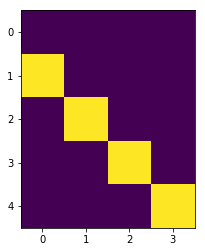

In [134]:
plt.imshow(almt1)

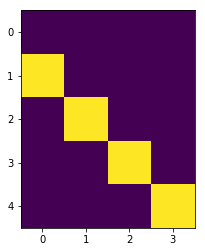

In [135]:
plt.imshow(almt2)

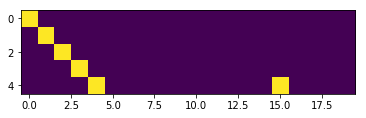

In [136]:
plt.imshow(mat1)

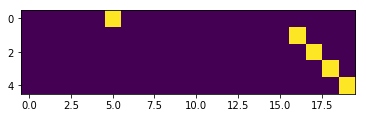

In [137]:
plt.imshow(mat2)

# Shrinkage

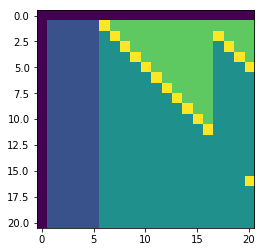

In [128]:
plt.imshow(bp)

In [181]:
def eval_shrinkage(bp, dp_max_x, dp_max_y, flip = False):
    row = dp_max_x
    col = dp_max_y
    print(row, col)
    # The first column is inserted just to avoid initialization error that may occur on concatination.
    alignment1 = np.zeros((mat1.shape[0], 1))
    alignment2 = np.zeros((mat1.shape[0], 1))
    zerovec = np.zeros(mat1.shape[0]) # which is corresponding to the null character.
    while True:
        if bp[row, col] == -1:
            # Eather of the strings tracing terminated
            break
        elif bp[row, col] == 3:
            row -= 1
            col -= 1
        elif bp[row, col] == 2:
            col -= 1
        elif bp[row, col] == 1:
            row -= 1
        elif bp[row, col] == 0:
            break
    if flip:
        return -(dp_max_x - row) / (dp_max_y - col)
    else:
        return (dp_max_x - row) / (dp_max_y - col)

In [153]:
sequence = np.eye(5)
mat1 = np.zeros((5, 20))
mat2 = np.zeros((5, 20))
mat1[:, 0:5] = sequence[:, :]
mat2[:, [10, 12, 14, 16, 18]] = sequence[:, :]

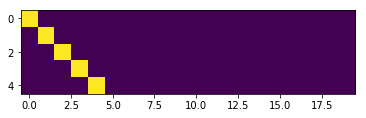

In [178]:
plt.imshow(mat1)

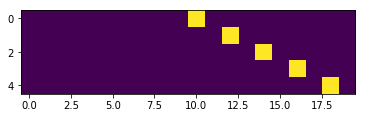

In [177]:
plt.imshow(mat2)

In [156]:
dp_max, dp_max_x, dp_max_y, bp = local_exp_editsim_withbp(mat1, mat2, a = 0.5)

In [157]:
eval_shrinkage(bp, dp_max_x, dp_max_y)

5 19


0.5555555555555556

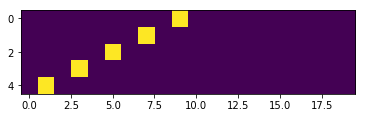

In [158]:
plt.imshow(mat2[:, ::-1])

In [159]:
def local_exp_editsim_withflip(mat1, mat2, a = 0.01):
    """
    Flip the second argument 'mat2'
    """
    dp_max1, dp_max_x1, dp_max_y1 = local_exp_editsim(mat1, mat2, a)
    dp_max2, dp_max_x2, dp_max_y2 = local_exp_editsim(mat1, mat2[:, ::-1], a)
    if dp_max1 >= dp_max2:
        return dp_max1, dp_max_x1, dp_max_y1
    else:
        return dp_max2, dp_max_x2, dp_max_y2

In [175]:
def local_exp_editsim_withbp_withflip(mat1, mat2, a = 0.01):
    """
    Flip the second argument 'mat2'
    """
    dp_max1, dp_max_x1, dp_max_y1, bp1 = local_exp_editsim_withbp(mat1, mat2, a)
    dp_max2, dp_max_x2, dp_max_y2, bp2 = local_exp_editsim_withbp(mat1, mat2[:, ::-1], a)
    print(dp_max1, dp_max2)
    if dp_max1 >= dp_max2:
        return dp_max1, dp_max_x1, dp_max_y1, bp1, False
    else:
        return dp_max2, dp_max_x2, dp_max_y2, bp2, True

In [179]:
dp_max, dp_max_x, dp_max_y, bp, flip = local_exp_editsim_withbp_withflip(mat1, mat2[:, ::-1], a = 0.01)
print(dp_max, dp_max_x, dp_max_y, bp, flip)

1.0 4.95979933166
4.95979933166 5 19 [[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  2.  2.  2.  2.  2.  2.
   2.  2.  2.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  3.  3.  2.  2.  2.  2.
   2.  2.  2.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  3.  3.  2.  2.
   2.  2.  2.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  3.  3.
   2.  2.  2.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.
   3.  3.  2.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  3.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.

In [182]:
eval_shrinkage(bp, dp_max_x, dp_max_y, flip = True)

5 19


-0.5555555555555556

In [1]:
from cython.parallel import prange
import Cython.Compiler.Options as CO
CO.extra_compile_args = ['-fopenmp']
CO.extra_link_args = ['-fopenmp']

In [5]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [15]:
%%cython -a
from cython.parallel import prange
import numpy as np
cimport cython
cimport openmp
cimport numpy as np
DBL = np.double
ctypedef np.double_t DBL_C
# def func(DBL_C[:, :] x):
#     for i in prange(x.shape[0], nogil=True):
#         x[i] = x[i]
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef cysumpar(np.ndarray[double] A):
    cdef double tot=0.
    cdef int i, n=A.size
    for i in prange(n, nogil=True):
        tot += A[i]
    return tot

CompileError: command '/usr/bin/clang' failed with exit status 1

In [14]:
cysumpar(np.random.random(1000000000))

499998038.52243364